In [7]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [8]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read_delim(url, col_names=FALSE, delim=",") %>% 
    select(X1, X4, X5, X14) %>% 
    mutate(X14 = as_factor(X14))

colnames(heart_data) <- c("age", "resting_bp", "cholesterol", "disease_presence")

heart_split <- initial_split(heart_data, prop = 0.75, strata = disease_presence) 
heart_train <- training(heart_split) 
# for later use
heart_test <- testing(heart_split)

heart_train


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,resting_bp,cholesterol,disease_presence
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
45,110,264,1
57,130,131,3
57,130,236,1


In [11]:
counts_of_disease_presence <- group_by(heart_train, disease_presence) %>%
    summarize(n=n())
counts_of_disease_presence

`summarise()` ungrouping output (override with `.groups` argument)



disease_presence,n
<fct>,<int>
0,122
1,42
2,28
3,26
4,11


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




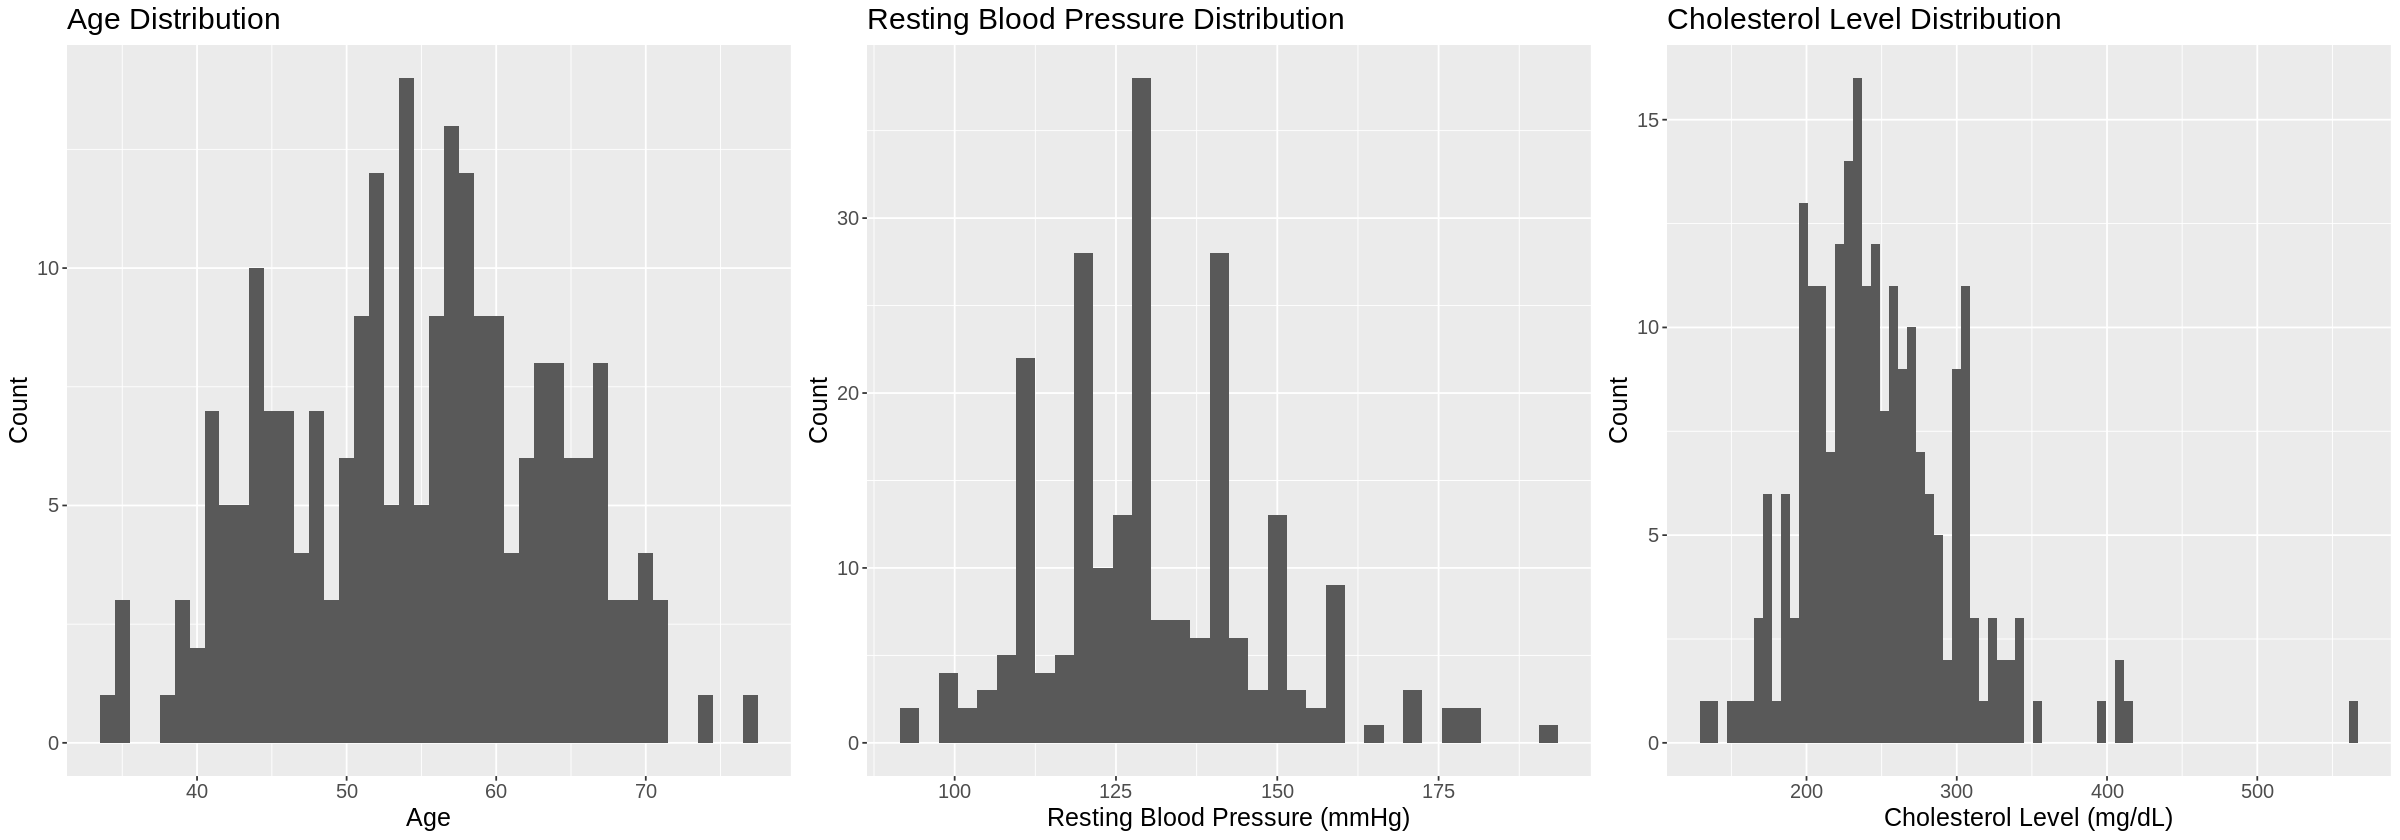

In [10]:
require(gridExtra)
options(repr.plot.height = 7, repr.plot.width = 20)
age_histogram <- ggplot(heart_train, aes(x = age)) +
    geom_histogram(binwidth = 1) +
    xlab("Age") +
    ylab("Count") +
    ggtitle("Age Distribution") +
    theme(text = element_text(size = 15))
resting_bp_histogram <- ggplot(heart_train, aes(x = resting_bp)) +
    geom_histogram(binwidth = 3) +
    xlab("Resting Blood Pressure (mmHg)") +
    ylab("Count") +
    ggtitle("Resting Blood Pressure Distribution") +
    theme(text = element_text(size = 15))
cholesterol_histogram <- ggplot(heart_train, aes(x = cholesterol)) +
    geom_histogram(binwidth = 6) +
    xlab("Cholesterol Level (mg/dL)") +
    ylab("Count") +
    ggtitle("Cholesterol Level Distribution") +
    theme(text = element_text(size = 15))

grid.arrange(age_histogram, resting_bp_histogram, cholesterol_histogram, ncol = 3)